# Shape Space

A key component in the analysis of shape collections is the notion of a shape space, i.e. a space in which every point corresponds to a particular shape.
We will follow a deformation-based approach where a common deformable template encodes the typicality of the object class under study.
The shape variability in turn is encoded by deformations of the template (referred to as reference shape in the following).

## Discrete representation

To obtain a computational model, we require a digital representation of shapes and variations thereof.
To this end, we employ triangular surface meshes for which we provide the `Surface` class.
A surface mesh is specified by a pair of matrices:

$v = \begin{bmatrix} x_0 & y_0 & z_0 \\ x_1 & y_1 & z_1 \\ & \vdots & \end{bmatrix} \in \mathbb{R}^{n \times 3}
\text{ and }
f = \begin{bmatrix} i_0 & j_0 & k_0 \\ i_1 & j_1 & k_1 \\ & \vdots & \end{bmatrix} \in \mathbb{R}^{m \times 3},$

where $v$ holds the coordinates of $n$ vertices and $f$ lists which vertices (i.e. indices thereof w.r.t. $v$) form each of $m$ triangles.
For example, we can create a tetrahedron like this:

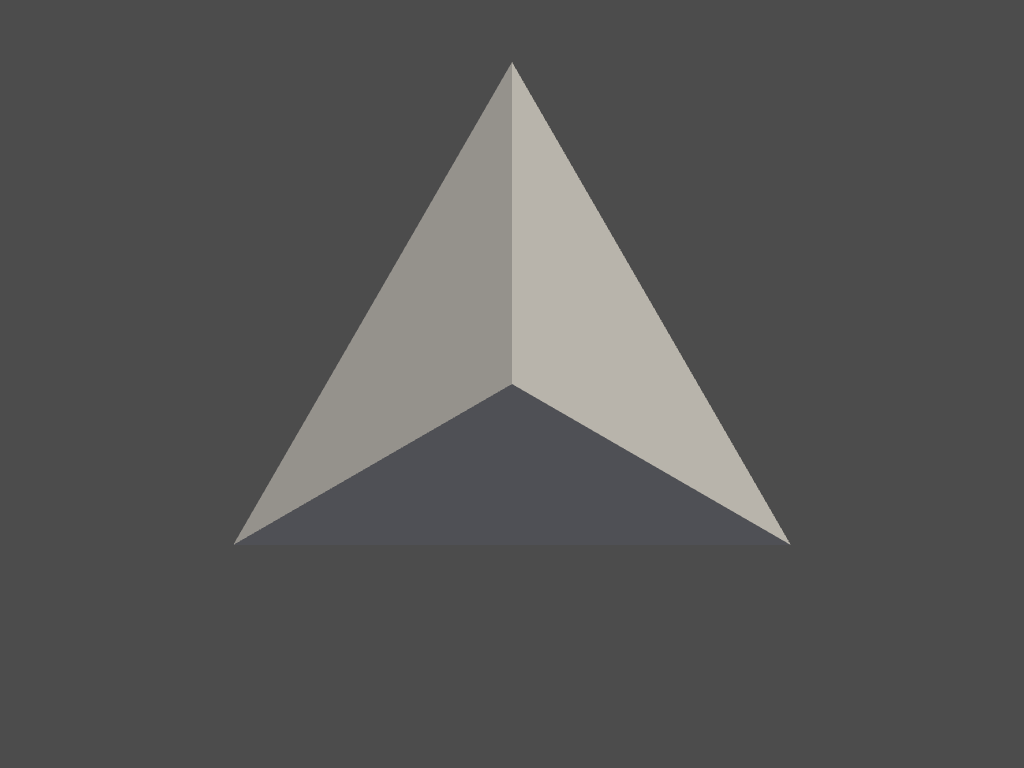

In [1]:
import numpy as np
import pyvista as pv
from morphomatics.geom import Surface

# 4 vertices
v = np.array([
    [0.57735, 0.57735, 0.57735],
    [-0.57735, 0.57735, -0.57735],
    [-0.57735, -0.57735, 0.57735],
    [0.57735, -0.57735, -0.57735]
])

# 4 triangles
# note: by sharing vertices (each is referenced 3 times), triangles are 'glued' together
f = np.array([
    [0, 3, 1],
    [1, 3, 2],
    [1, 2, 0],
    [0, 2, 3]
])

S = Surface(v, f)

# compute area of surface
S.face_areas.sum()

# plot the tetrahedron
pl = pv.Plotter(notebook=True)
pl.add_mesh(pv.PolyData(S.v, np.c_[np.full(len(S.f), 3), S.f]))
pl.show(jupyter_backend='static')

In order to encode deformations, hence shape variations, we focus on simplicial maps, i.e. deformations that map triangles onto triangles and are entirely determined by the images of the vertices.
Given a triangulated reference shape $(\bar{v}, \bar{f})$, each surface in a collection can be represented by a mesh with same connectivity $f_i \equiv \bar{f}$ and mapped vertices $v_i = \phi_i(\bar{v})$.

## Shape Representation

In the theoretical part of this tutorial we learned about two different representations:

* __Point distribution model__ (see `morphomatics.manifold.PointDistributionModel`)
    A linearized, i.e. Euclidean, shape space mainly for comparison purposes.
    Rotational and translational effects are reduced via Procrustes alignment to the reference shape.


* __Fundamental coordinates model__ (see `morphomatics.manifold.FundamentalCoords`)
   A surface-theoretic approach that is invariant under Euclidean motion and thus alignment-free.
   The rich structure of the derived shape space assures valid shape instances even in presence of strong nonlinear variability.
   The representation builds upon metric distortion and curvature of shapes as elements of Lie groups that allow for closed-form evaluation of Riemannian operations.

Both implementations share a common ancestor `ShapeSpace` (in `morphomatics.manifold.ShapeSpae`).

## Task 1 on Geodesic interpolation
Choose different values for `nInterpol`.
- What is your impression?

Choose different shape spaces (FundamentalCoords, PointDistributionModel).
- What can you say about the difference between FCM and PDM, regarding shape interpolation?

distance:  1.1925920903745901


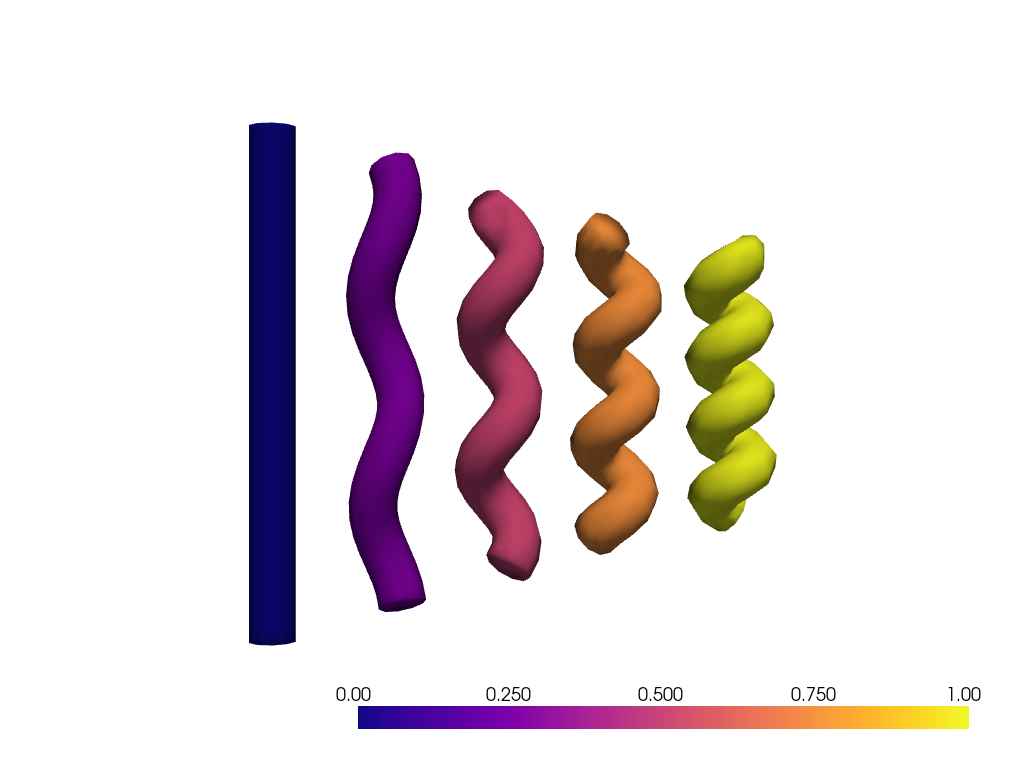

In [15]:
nInterpol=5 # e.g. 5, 10, 20

from morphomatics.manifold import FundamentalCoords, PointDistributionModel, util

# Read example data

mesh_straight = pv.read('./tutorial2_pop_med_image_shape_ana/data/straight.obj')
mesh_helix = pv.read('./tutorial2_pop_med_image_shape_ana/data/helix.obj')

as_surface = lambda mesh: Surface(mesh.points, mesh.faces.reshape(-1, 4)[:, 1:])
S_straight = as_surface(mesh_straight)
S_helix = as_surface(mesh_helix)

# Construct shape space
M = FundamentalCoords(S_straight) # Replace with PointDistributionModel

# map surfaces to shape space coordinates
c_straight = M.to_coords(S_straight.v)
c_helix = M.to_coords(S_helix.v)

# perform computations, e.g. ...

# ... compute distance
print('distance: ', M.metric.dist(c_straight, c_helix))

# ... interpolate surfaces (mid-point on geodesic)
diff = M.connec.log(c_straight, c_helix)
mean = M.connec.exp(c_straight, 0.5*diff)


# visualize
pv.set_plot_theme('document')
pl = pv.Plotter(notebook=True)
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap("plasma")
v = S_straight.v # align to this for visualization
for t in np.linspace(0,1,nInterpol):
     # compute interpolating shape
     v_ = M.from_coords(M.connec.exp(c_straight, t*diff))
     # align and move upwards
     v = util.align(v_, v) + np.array([0.,0.,10/nInterpol])
     # add to plot
     pl.add_mesh(pv.PolyData(v, mesh_straight.faces), scalars=np.full_like(v[:,0], t), cmap=cmap, smooth_shading=True)
pl.view_zx()
pl.show(jupyter_backend='static')



In [16]:
""" Client-side rendering with `ipygany` and `ipywidgets` for interaction. """

from ipywidgets import interact

# create viewer
pv.set_plot_theme('document')
pv.global_theme.color = '#008c04'

# setup plotter with mean shape
pl = pv.Plotter(notebook=True)
v = M.from_coords(M.connec.exp(c_straight, .5*diff))
mesh = pv.PolyData(v, np.c_[np.full(len(S_straight.f), 3), S_straight.f])
pl.add_mesh(mesh)

# adjust camera
pl.view_xy()

viewer = pl.show(jupyter_backend='ipygany', return_viewer=True, full_screen=True)

@interact
def plot(t=(0,1,.01)):
    # interpolate: walk along connecting geodesic
    v = M.from_coords(M.connec.exp(c_straight, t*diff))
    viewer.children[0].vertices = v

    
viewer


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

Scene(background_color='#ffffff', camera={'position': [-1.8450779586494883, 1.232236940221279, 8.3197547817252…